In [1]:
import numpy as np
import matplotlib.pyplot as plt
from eigenfaces import DimensionalityReduction
from sklearn.decomposition import PCA

from faceProcessing import create_vector_and_matrix
from facesExample import dictionary_of_names, dictionary_of_mathematicians
from helper_functions import reconstruct_images, plot_images, get_closest_point, get_difference_image

First we load our images, image_matrix contains pixel data of each image, image_vector contains labels (extensions in this case)

In [2]:
image_vector, image_matrix = create_vector_and_matrix('https://sluzby.fmph.uniba.sk/f/', list(dictionary_of_names.keys()))
mathematician_vector, mathematician_matrix = create_vector_and_matrix('', list(dictionary_of_mathematicians.values()))

We can reconstruct each image by using reconstruct_images function

In [3]:
original_images = reconstruct_images(image_matrix, 100, 100)
mathematician_images = reconstruct_images(mathematician_matrix, 100, 100)

In [4]:
print(image_matrix.shape)
print(mathematician_matrix.shape)

(174, 10000)
(4, 10000)


Small sample of our images

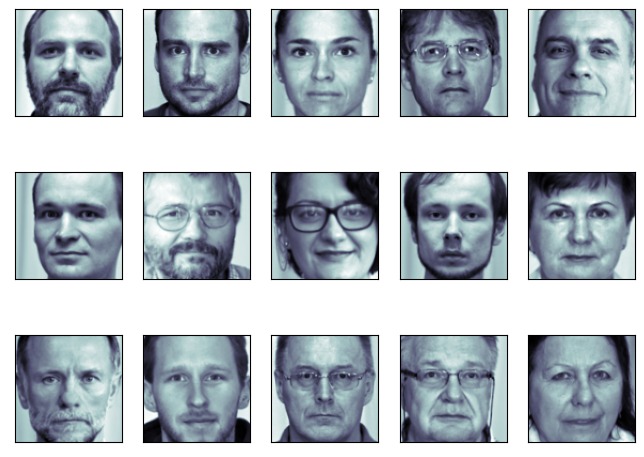

In [5]:
plot_images(original_images, 3, 5)

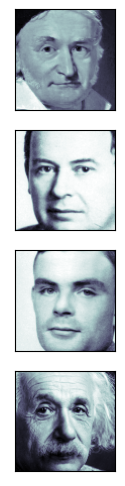

In [6]:
plot_images(mathematician_images, len(mathematician_images), 1)

First PCA is imported from sklearn, second PCA, pca_alt, is our own version. 
pca_alt will be used mostly for comparison. 
Setting the n_components parameter to value 0<n<1 gives us the required amount of components needed to achieve explained variance >=n

In [7]:
pca = PCA(n_components = 0.95, whiten = True)
reduced_image_matrix = pca.fit_transform(image_matrix)
reduced_math_image_matrix = pca.transform(mathematician_matrix)

In this case its 75 components

In [8]:
pca.components_.shape

(75, 10000)

In [9]:
pca_alt = DimensionalityReduction()
reduced_image_matrix_alt = pca_alt.fit_transform(image_matrix, 150)

These are the average faces calculated from both algorithms (sklearn pca is first image, ours is second)

In [10]:
avg_face_1 = reconstruct_images([pca.mean_], 100, 100)[0]
avg_face_2 = reconstruct_images([pca_alt.avg_vector[0]], 100, 100)[0]

In [11]:
feature_faces = reconstruct_images(pca.components_[:30], 100, 100)
feature_faces_alt = reconstruct_images(pca_alt.e_vec.T[:30,:], 100, 100)

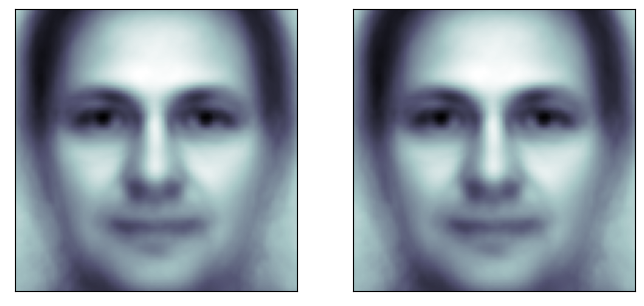

In [12]:
plot_images([avg_face_1, avg_face_2], 1, 2, (8, 8))

It would seem that our average faces are identical -> the difference between all of the pixes is 0

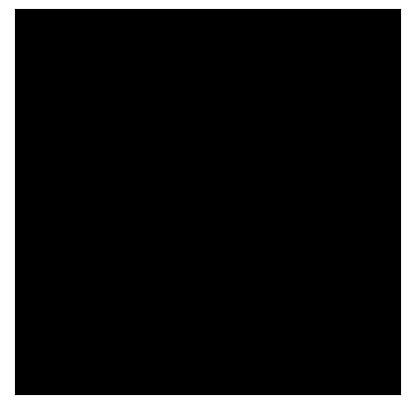

In [13]:
difference_image = get_difference_image(avg_face_1, avg_face_2)
plot_images([difference_image], 1, 1, (5,5))

These are the feature faces of sklearn pca

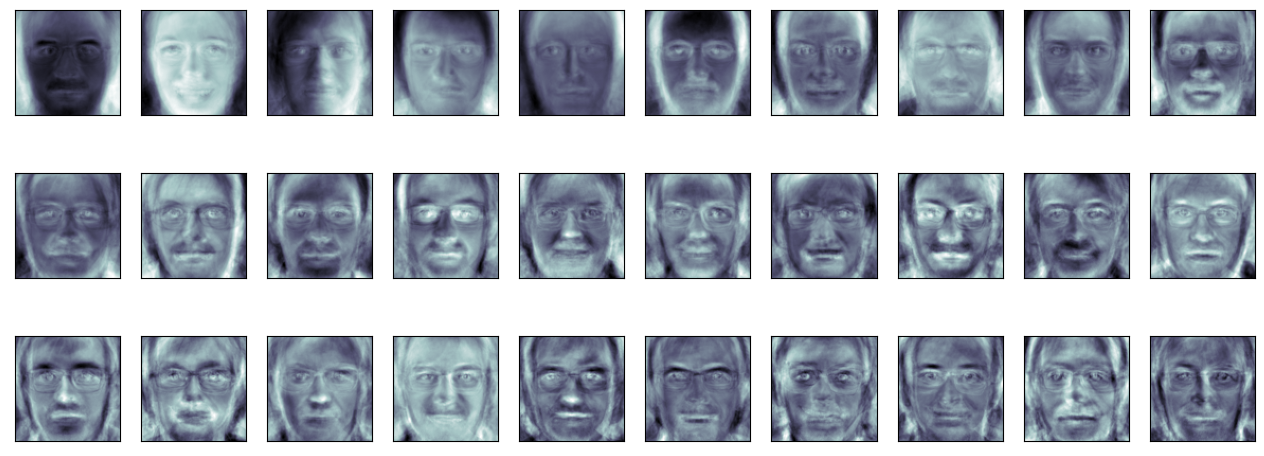

In [14]:
plot_images(feature_faces, 3, 10, (16,6))

feature faces made using our algorithm, they are very similar, though not completely identical, lot of features seem to just have their lightning flipped

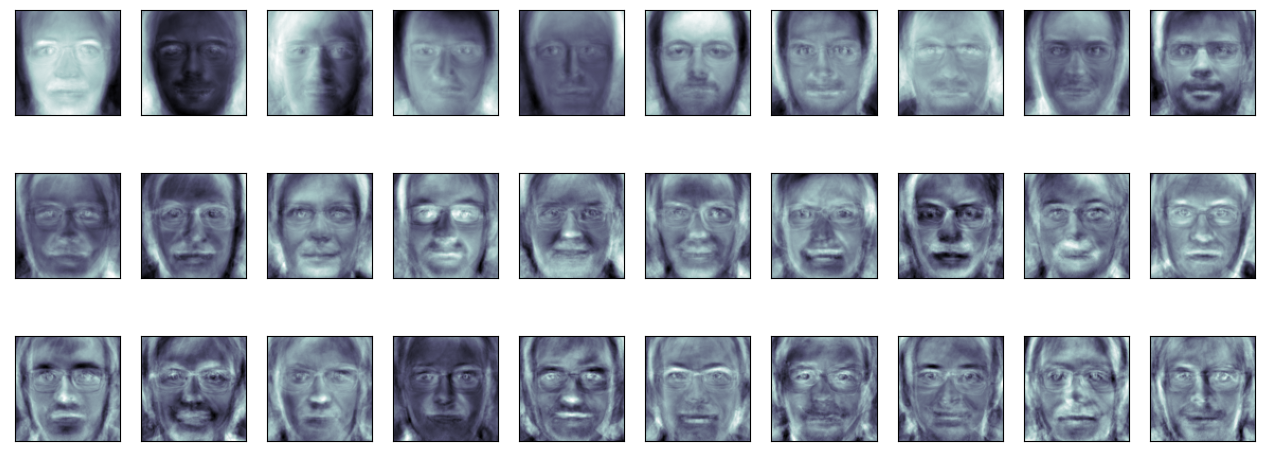

In [15]:
plot_images(feature_faces_alt, 3, 10, (16,6))

This was just a little test to see, if we can find some ineteresting combination of features, but they dont really group well together

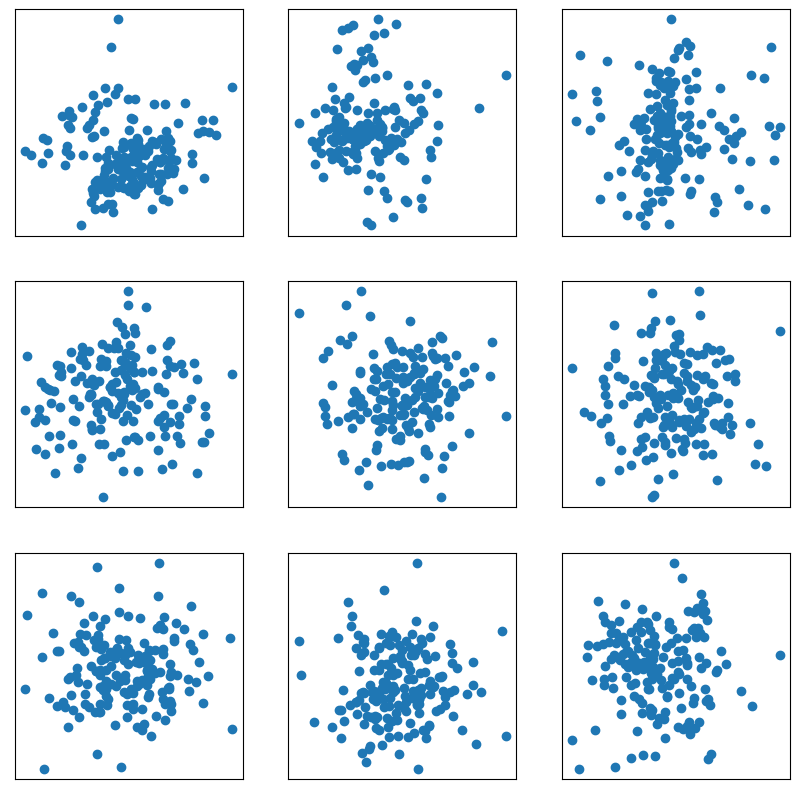

In [16]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.scatter(reduced_image_matrix[:, i], reduced_image_matrix[:, i + 1])

Here we search for faculty members who most resemble famous mathematicians, we just use the closest person, based on their euclidean distance of facial features

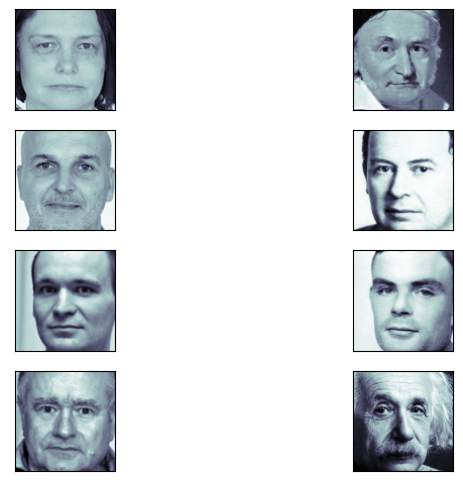

In [17]:
feature_num = 15
closest_images = []
for image in reduced_math_image_matrix:
    closest_images.append(get_closest_point(reduced_image_matrix[:, :feature_num], image[:feature_num]))

fig = plt.figure(figsize=(8, 6))
for i, idx in enumerate(closest_images):
    ax = fig.add_subplot(len(reduced_math_image_matrix), 2, i*2 + 1, xticks=[], yticks=[])
    ax.imshow(original_images[idx], cmap=plt.cm.bone)
    ax = fig.add_subplot(len(reduced_math_image_matrix), 2, i*2 + 2, xticks=[], yticks=[])
    ax.imshow(mathematician_images[i], cmap=plt.cm.bone)

CLUSTERING PART

We test 3 different clustering methods:
1. Sklearn kmeans
2. Our own kmeans
3. Gaussian Mixture algorithm

In [18]:
from sklearn.cluster import KMeans
from eigenfaces import ClusteringKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Using silhouetter_score and elbow method, we can determine the optimal amount of clusters for our algorithm. 
https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

In [19]:
### Some params we can adjust
r_state = 4
kmax = 100
first_c = 0 # first feature we take into consideration
last_c = 15 # last feature we take into consideration

In [20]:
sil = []
inertia = []
for i in range(2, kmax+1):
    kmeans = KMeans(n_clusters = i, n_init = 10, random_state = r_state).fit(reduced_image_matrix[:, first_c:last_c])
    kmeans_labels = kmeans.labels_
    sil.append(silhouette_score(reduced_image_matrix[:, first_c:last_c], kmeans_labels, metric = 'euclidean'))
    inertia.append(kmeans.inertia_)
    
kmeans_optimal_n_of_clusters = sil.index(max(sil)) + 2

Here we can see the optimal amount of clusters (according to silhouette score)

In [21]:
print(kmeans_optimal_n_of_clusters)

30


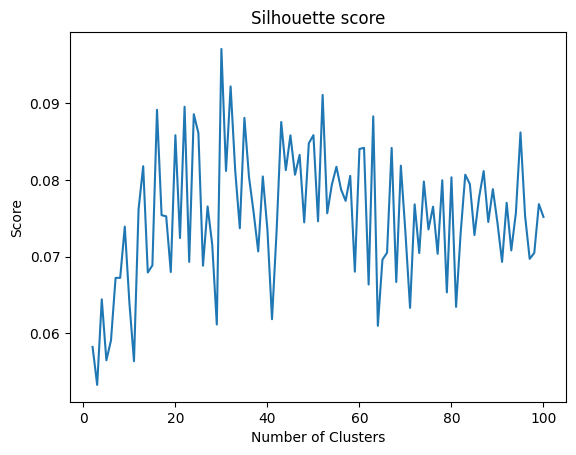

In [22]:
plt.plot(range(2, kmax+1), sil)
plt.title('Silhouette score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

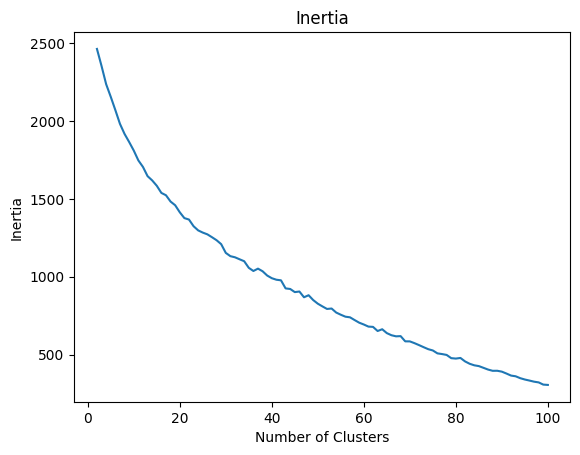

In [23]:
plt.plot(range(2, kmax+1), inertia)
plt.title('Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

We will use these values to create seemingly optimal clustering

In [24]:
kmeans = KMeans(n_clusters = kmeans_optimal_n_of_clusters, n_init = 10, random_state = r_state).fit(reduced_image_matrix[:, first_c:last_c])
kmeans_labels = kmeans.labels_
kmeans_groups = [[] for i in range(kmeans_optimal_n_of_clusters)]
for i in range(len(kmeans_labels)):
    kmeans_groups[kmeans_labels[i]].append(original_images[i])

In [25]:
for i, group in enumerate(kmeans_groups):
    print(f'Group {i}: {len(group)}')

Group 0: 4
Group 1: 9
Group 2: 2
Group 3: 11
Group 4: 7
Group 5: 8
Group 6: 11
Group 7: 13
Group 8: 3
Group 9: 11
Group 10: 2
Group 11: 4
Group 12: 1
Group 13: 1
Group 14: 6
Group 15: 9
Group 16: 4
Group 17: 1
Group 18: 2
Group 19: 2
Group 20: 6
Group 21: 6
Group 22: 4
Group 23: 3
Group 24: 4
Group 25: 11
Group 26: 14
Group 27: 5
Group 28: 2
Group 29: 8


This is a solid representative group, if you want to see other groups, just change the group_no

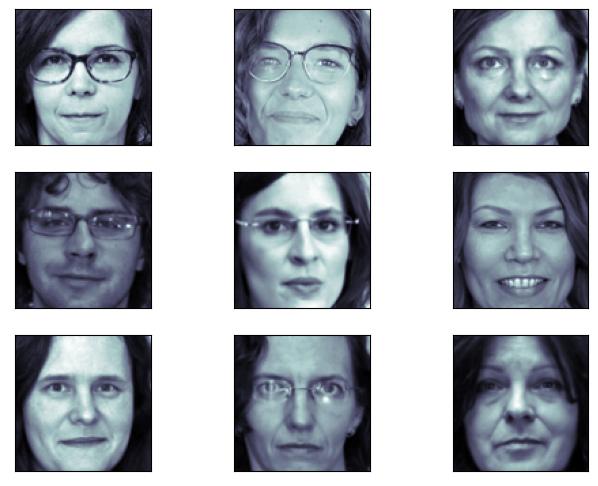

In [26]:
group_no = 6
plot_images(kmeans_groups[group_no], 3, 3)

We also try the Gauissian Mixture algorithm, we will use the same amount of components that are optimal for kmeans

In [27]:
sil = []
for i in range(2, kmax+1):
    gaussian_mixture = GaussianMixture(n_components = i, random_state = r_state)
    gaussian_mixture.fit(reduced_image_matrix[:, first_c:last_c])
    gaussian_labels = gaussian_mixture.predict(reduced_image_matrix[:, first_c:last_c])
    sil.append(silhouette_score(reduced_image_matrix[:, first_c:last_c], gaussian_labels, metric = 'euclidean'))
    
gaussian_optimal_n_of_clusters = sil.index(max(sil)) + 2

In [28]:
gaussian_mixture = GaussianMixture(n_components=gaussian_optimal_n_of_clusters, random_state = r_state)
gaussian_mixture.fit(reduced_image_matrix[:, first_c:last_c])
gaussian_labels = gaussian_mixture.predict(reduced_image_matrix[:, first_c:last_c])

In [29]:
gaussian_groups = [[] for i in range(gaussian_optimal_n_of_clusters)]
for i in range(len(gaussian_labels)):
    gaussian_groups[gaussian_labels[i]].append(original_images[i])

In [30]:
for i, group in enumerate(gaussian_groups):
    print(f'Group {i}: {len(group)}')

Group 0: 12
Group 1: 14
Group 2: 11
Group 3: 20
Group 4: 20
Group 5: 11
Group 6: 8
Group 7: 11
Group 8: 6
Group 9: 1
Group 10: 10
Group 11: 6
Group 12: 4
Group 13: 6
Group 14: 10
Group 15: 3
Group 16: 11
Group 17: 2
Group 18: 4
Group 19: 4


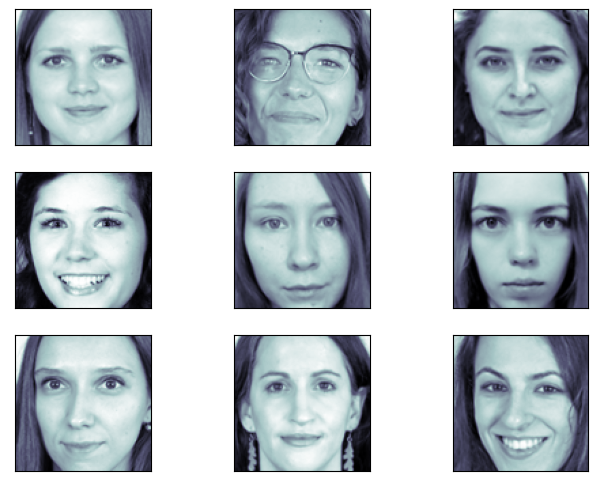

In [31]:
group_no = 10
plot_images(gaussian_groups[group_no], 3, 3)

Its difficult to objectively assess the accuracy of our models, since we have many dimensions and we are only clustering the faces, based on their visual similarity (features).

In [32]:
from helper_functions import create_colors

Here we can see the difference in clustering between kmeans and gaussian mixture using the same sets of data. They are pretty similar.

First column is K-Means, second is Gaussian Mixture

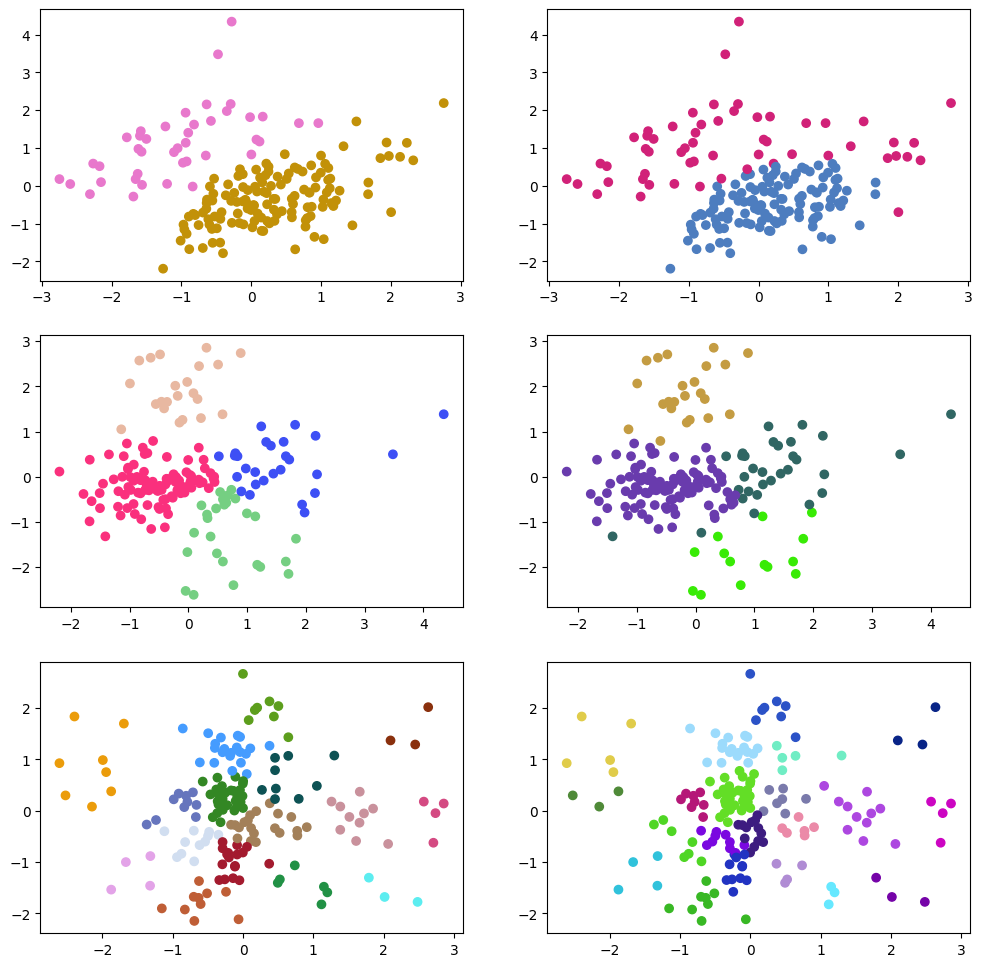

In [33]:
plt.rcParams["figure.figsize"] = (12,12) 
kmax = 25
for j in range(0, 3):
    kmeans_sil = []
    gaussian_sil = []
    
    # Get the optimal amount of clusters for kmeans
    for i in range(2, kmax+1):
        kmeans = KMeans(n_clusters = i, n_init = 10, random_state = r_state)
        kmeans.fit(reduced_image_matrix[:, [j, j+1]])
        labels = kmeans.labels_
        kmeans_sil.append(silhouette_score(reduced_image_matrix[:, [j, j+1]], labels, metric = 'euclidean'))
        
    # Get the optimal amount of clusters for gaussian mixture
    for i in range(2, kmax+1):
        gaussian_mixture = GaussianMixture(n_components = i, random_state = r_state)
        gaussian_mixture.fit(reduced_image_matrix[:, [j, j+1]])
        labels = gaussian_mixture.predict(reduced_image_matrix[:, [j, j+1]])
        gaussian_sil.append(silhouette_score(reduced_image_matrix[:, [j, j+1]], labels, metric = 'euclidean'))

    optimal_n_of_clusters = kmeans_sil.index(max(kmeans_sil)) + 2
    kmeans = KMeans(n_clusters = optimal_n_of_clusters, n_init = 10, random_state = r_state).fit(reduced_image_matrix[:, [j, j+1]])
    labels = kmeans.labels_
    kmeans_cols = create_colors(labels, kmeans_optimal_n_of_clusters)
    
    optimal_n_of_clusters = gaussian_sil.index(max(gaussian_sil)) + 2
    gaussian_mixture = GaussianMixture(n_components = optimal_n_of_clusters, random_state = r_state).fit(reduced_image_matrix[:, [j, j+1]])
    labels = gaussian_mixture.predict(reduced_image_matrix[:, [j, j+1]])
    gaussian_cols = create_colors(labels, optimal_n_of_clusters)
    
    plt.subplot(3,2,1+j*2)
    plt.scatter(reduced_image_matrix[:, j], reduced_image_matrix[:, j + 1], c = kmeans_cols)
    plt.subplot(3,2,2+j*2)
    plt.scatter(reduced_image_matrix[:, j], reduced_image_matrix[:, j + 1], c = gaussian_cols)
